# Logistic regression on Criteo dataset with Spark MLlib

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import types as st
from pyspark.sql import functions as sf
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark import StorageLevel

In [2]:
%matplotlib inline

In [3]:
from scipy.special import expit
import matplotlib.pyplot as plot

In [4]:
ss = SparkSession \
    .builder \
    .appName("criteo-lr") \
    .master("local[4]") \
    .config("spark.submit.deployMode", "client") \
    .config("spark.driver.memory", "4g") \
    .config("spark.ui.port", "0") \
    .getOrCreate()
ss

## Load dataset

In [6]:
integer_features = [f"int_feat_{i}" for i in range(1, 14)]
categorical_features = [f"cat_feat_{i}" for i in range(1, 27)]

fields = []

fields.append(
    st.StructField("label", st.IntegerType(), nullable=False)
)

for int_feat in integer_features:
    fields.append(st.StructField(int_feat, st.IntegerType(), nullable=True))
    
for cat_feat in categorical_features:
    fields.append(st.StructField(cat_feat, st.StringType(), nullable=True))

schema = st.StructType(fields)

In [7]:
full_df = ss.read.csv(
    path="file:///home/m.tchiboukdjian/master-iasd/large-scale-ml/train.txt",
    sep="\t",
    header=None,
    schema=schema
)

In [8]:
# don't run this cell to use the full dataset
full_df = full_df.sample(0.1).persist(StorageLevel.DISK_ONLY)

In [9]:
full_df.agg(
    sf.count('*').alias('num_examples'),
    sf.sum('label').alias('num_positives'),
    sf.sum(sf.expr('label == 0').cast('int')).alias('num_negatives'),
    sf.mean('label').alias('avg_label')
).toPandas()

,num_examples,num_positives,num_negatives,avg_label
0,4584122,1174584,3409538,0.256229


In [10]:
train_df, test_df = full_df.randomSplit([0.8, 0.2])

## Feature Hashing

In [11]:
hasher = FeatureHasher()\
    .setInputCols(categorical_features)\
    .setCategoricalCols(categorical_features)\
    .setNumFeatures(2 ** 16)\
    .setOutputCol("features")

In [12]:
hashed_df = hasher.transform(train_df)

In [14]:
hashed_df.select('features').show(4, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                      |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(65536,[1273,9877,15085,21563,22469,26699,27442,27890,35986,39921,41642,45348,46564,46835,51690,53310,53441,55318,56600,58699,59537,64150],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,

## Logistic Regression

In [15]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=10.0,
    tol=1e-06
)

In [16]:
lr_model = lr.fit(hashed_df)

In [17]:
lr_model.intercept, expit(lr_model.intercept)

(-1.076280920415807, 0.25421046292195104)

In [18]:
len(lr_model.coefficients)

65536

(array([1.800e+01, 7.400e+01, 1.620e+02, 3.590e+02, 6.370e+02, 1.109e+03,
        1.805e+03, 2.831e+03, 3.800e+03, 5.109e+03, 6.378e+03, 7.092e+03,
        7.193e+03, 6.486e+03, 5.664e+03, 4.538e+03, 3.464e+03, 2.573e+03,
        1.813e+03, 1.120e+03, 8.330e+02, 7.060e+02, 4.360e+02, 3.440e+02,
        2.320e+02, 1.790e+02, 1.410e+02, 8.600e+01, 6.500e+01, 5.800e+01,
        5.100e+01, 4.600e+01, 3.300e+01, 2.800e+01, 1.600e+01, 1.600e+01,
        1.100e+01, 9.000e+00, 6.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.02037121, -0.01875693, -0.01714264, -0.01552836, -0.01391407,
        -0.01229979, -0.0106855 , -0.00907122, -0.00745693, -0.00584265,
        -0.00422837, -0.00261408, -0.0009998 ,  0.00061449,  0.00222877,
         0.00384306,  0.00545734,  0.00707163,  0.00868591,  0.01030019,
         0.01191448,  0.01352876,  0.01514305,  0.01675733,  0.01837162,


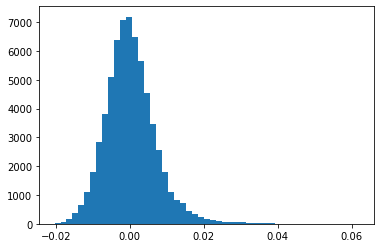

In [21]:
plot.hist(lr_model.coefficients, bins=51)

## Pipeline

In [22]:
pipeline = Pipeline(stages=[hasher, lr])

In [23]:
lr_model_with_hasher = pipeline.fit(train_df)

In [24]:
lr_model_with_hasher.stages

[FeatureHasher_9f27ea385ae6,
 LogisticRegressionModel: uid = LogisticRegression_c240199fcbea, numClasses = 2, numFeatures = 65536]

## Evaluation

In [25]:
test_df_with_pred = lr_model_with_hasher.transform(test_df)

In [27]:
test_df_with_pred.select('probability').show(10, False)

+----------------------------------------+
|probability                             |
+----------------------------------------+
|[0.7229415716995374,0.2770584283004625] |
|[0.7598638962240658,0.24013610377593414]|
|[0.7605365373894056,0.2394634626105944] |
|[0.745089578062862,0.2549104219371379]  |
|[0.7555870601702451,0.2444129398297549] |
|[0.7548281171764062,0.24517188282359378]|
|[0.7558073396092361,0.24419266039076387]|
|[0.7562528901527084,0.24374710984729162]|
|[0.770773750924506,0.22922624907549397] |
|[0.7574871121658973,0.24251288783410277]|
+----------------------------------------+
only showing top 10 rows



In [28]:
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="rawPrediction",
    labelCol="label",
    metricName="areaUnderROC"
)

In [29]:
evaluator.evaluate(test_df_with_pred)

0.7184818311995048

## Optional: Add integer features

In [30]:
ss.stop()